# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

import xgboost as xgb
from xgboost import plot_importance

import gc

import warnings
warnings.filterwarnings("ignore")

# Step 2: Load the Data

In [2]:
train_path = '/kaggle/input/drw-crypto-market-prediction/train.parquet'
test_path = '/kaggle/input/drw-crypto-market-prediction/test.parquet'

train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (525887, 896)
Test shape: (538150, 896)


In [3]:
# ✅ No conversion needed, just sort by index (already datetime)
train_df = train_df.sort_index()
print(train_df.index[:5])  # Confirm it's datetime

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 00:01:00',
               '2023-03-01 00:02:00', '2023-03-01 00:03:00',
               '2023-03-01 00:04:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


In [4]:
print(train_df.head())
print(train_df.columns)

                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ...  1.928047   
2023-03-01 00:03:00 -0.436590 -0.102483  0.017551  0.007

In [5]:
print(test_df.columns)

Index(['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3',
       'X4', 'X5',
       ...
       'X882', 'X883', 'X884', 'X885', 'X886', 'X887', 'X888', 'X889', 'X890',
       'label'],
      dtype='object', length=896)


# Step 3: EDA

In [6]:
# EDA: Missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# EDA: Inf values
print("Inf values in train:")
print(np.isinf(train_df).sum())

print("Inf values in test:")
print(np.isinf(test_df).sum())

bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64
bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64
Inf values in train:
bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64
Inf values in test:
bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64


In [7]:
print(train_df['label'].describe())

count    525887.000000
mean          0.036126
std           1.009914
min         -24.416615
25%          -0.381585
50%           0.016262
75%           0.434135
max          20.740270
Name: label, dtype: float64


### What Do I Think About It?

* Centered around 0: The median is ~0.016 and the mean is ~0.036 — very close to 0.

* Highly concentrated: 50% of the data lies between -0.38 and 0.43 — a narrow range.

* Some extreme outliers: Min = -24.4 and Max = 20.7. These are far from the center, but rare (long tails).

* Standard deviation ~1: This suggests that most values are within [-1, 1], consistent with the histogram being peaked around 0.



In [8]:
print(train_df['label'].value_counts())

label
 0.562539    1
-0.080454    1
-0.531737    1
-0.421255    1
-0.377301    1
            ..
 0.523804    1
 0.436157    1
 0.598660    1
-0.168196    1
 0.731542    1
Name: count, Length: 525887, dtype: int64


### Interpretation of value_counts():

* Every value in the 'label' column appears only once.

* The total number of unique values is exactly the same as the number of rows: 525,887 unique values.

* So this is purely continuous data with no duplicates at all.

### What This Means:

* Your target variable is not categorical, not ordinal, and not rounded — it's a real-valued continuous variable (likely regression).

* This further confirms that the histogram peak near 0 is not due to repeated values like many zeros, but due to density: more values are close to 0, fewer are in the tails.

* This is typical in financial data (like log returns), residuals, or normalized scores.

In [9]:
print(train_df['label'].head(20))

timestamp
2023-03-01 00:00:00    0.562539
2023-03-01 00:01:00    0.533686
2023-03-01 00:02:00    0.546505
2023-03-01 00:03:00    0.357703
2023-03-01 00:04:00    0.362452
2023-03-01 00:05:00    0.100448
2023-03-01 00:06:00    0.178679
2023-03-01 00:07:00    0.463684
2023-03-01 00:08:00    0.686066
2023-03-01 00:09:00    0.637539
2023-03-01 00:10:00    0.907684
2023-03-01 00:11:00    0.846204
2023-03-01 00:12:00    0.753024
2023-03-01 00:13:00    0.397538
2023-03-01 00:14:00    0.373591
2023-03-01 00:15:00    0.415633
2023-03-01 00:16:00    0.372834
2023-03-01 00:17:00    0.311446
2023-03-01 00:18:00    0.205634
2023-03-01 00:19:00    0.226965
Name: label, dtype: float64


In [10]:
print("Any NaNs?", train_df.isna().sum().sum(), test_df.isna().sum().sum())
print("Any Infs?", np.isinf(train_df.to_numpy()).sum(), np.isinf(test_df.to_numpy()).sum())

Any NaNs? 0 0
Any Infs? 11043627 11301150


Those are huge numbers of inf values:

* 11+ million infs in train

* 11+ million infs in test

That’s a very significant portion of the data and likely coming from specific features.

### Why This Is a Problem

* These values will break most models, or make them behave unpredictably.

* If the infs come from only a few columns, it’s best to drop those columns entirely.

* If they are spread everywhere, you’ll need to decide whether to fill or clip them.

In [11]:
# Count inf values per column
inf_counts = pd.DataFrame({
    'train_inf': np.isinf(train_df).sum(axis=0),
    'test_inf': np.isinf(test_df).sum(axis=0)
})

# Filter only columns with inf values
inf_cols = inf_counts[(inf_counts['train_inf'] > 0) | (inf_counts['test_inf'] > 0)]
print("Columns with inf values:")
print(inf_cols.sort_values(by='train_inf', ascending=False))

Columns with inf values:
      train_inf  test_inf
X697     525887    538150
X708     525887    538150
X716     525887    538150
X715     525887    538150
X714     525887    538150
X713     525887    538150
X712     525887    538150
X711     525887    538150
X710     525887    538150
X709     525887    538150
X707     525887    538150
X698     525887    538150
X706     525887    538150
X705     525887    538150
X704     525887    538150
X703     525887    538150
X702     525887    538150
X701     525887    538150
X700     525887    538150
X699     525887    538150
X717     525887    538150


## What I Found?

The following 21 features (X697 through X717) contain only inf values in every row:

* train_inf = 525,887 (every row in train)

* test_inf = 538,150 (every row in test)

This means:

* These columns are completely unusable — they carry no real signal, just garbage (infinite values).

* They will crash or severely bias your model if not removed.

In [12]:
# Drop columns with inf values from both train and test
cols_to_drop = list(inf_cols.index)
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

## Check for Outliers

In [13]:
# Count how many values are outside [-10, 10]
outliers = (train_df['label'].abs() > 10).sum()
print(f"Number of extreme outliers (|label| > 10): {outliers}")

# View a few of them
print(train_df[train_df['label'].abs() > 10].sort_values(by='label'))


Number of extreme outliers (|label| > 10): 126
                     bid_qty  ask_qty    buy_qty   sell_qty     volume  \
timestamp                                                                
2023-10-16 13:31:00    0.486    0.031  16607.675  12093.744  28701.419   
2023-10-16 13:32:00    0.339    0.109   5992.858   9033.886  15026.744   
2023-10-16 13:30:00    4.363    2.992  12887.120   7755.539  20642.659   
2023-10-16 13:33:00    0.261    0.416   4787.575   6300.171  11087.746   
2023-08-17 21:35:00  200.975    5.871     66.086    117.663    183.749   
...                      ...      ...        ...        ...        ...   
2023-08-29 14:18:00   26.656    1.012    949.014    495.897   1444.911   
2023-08-29 14:17:00    0.040    0.408    326.730    393.970    720.700   
2023-08-29 14:19:00    4.933    3.822    236.775    628.396    865.171   
2023-08-29 14:20:00    7.170   10.971    216.638    253.498    470.136   
2023-08-17 21:45:00    0.076    0.414   9379.148  12825.470  2220

### Outlier Summary:

* There is 126 outliers with |label| > 10, out of 525,887 rows.

* That’s ~0.024% of the data — very rare, but they are extreme (as low as -24.4 and as high as +20.7).

* These outliers might:

    * Skew our loss function (especially MSE or linear regression).

    * Indicate rare but important events (e.g., market shocks).

    * Require special handling like clipping, log transform, or robust loss functions (like Huber).

## Plot the Distribution

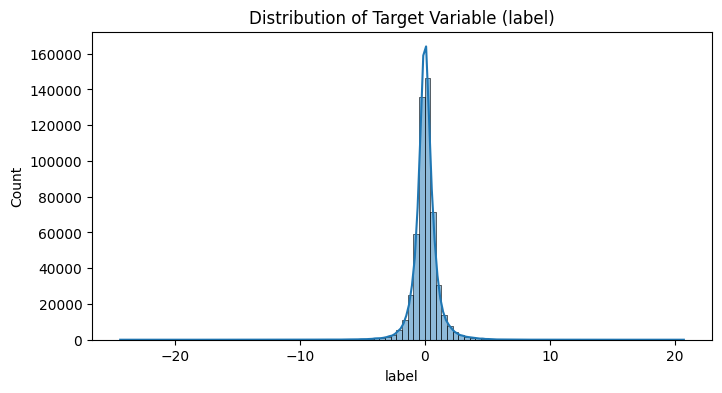

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['label'], bins=100, kde=True)
plt.title("Distribution of Target Variable (label)")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

## Plotting the target over time to see trends, cycles, or spikes visually

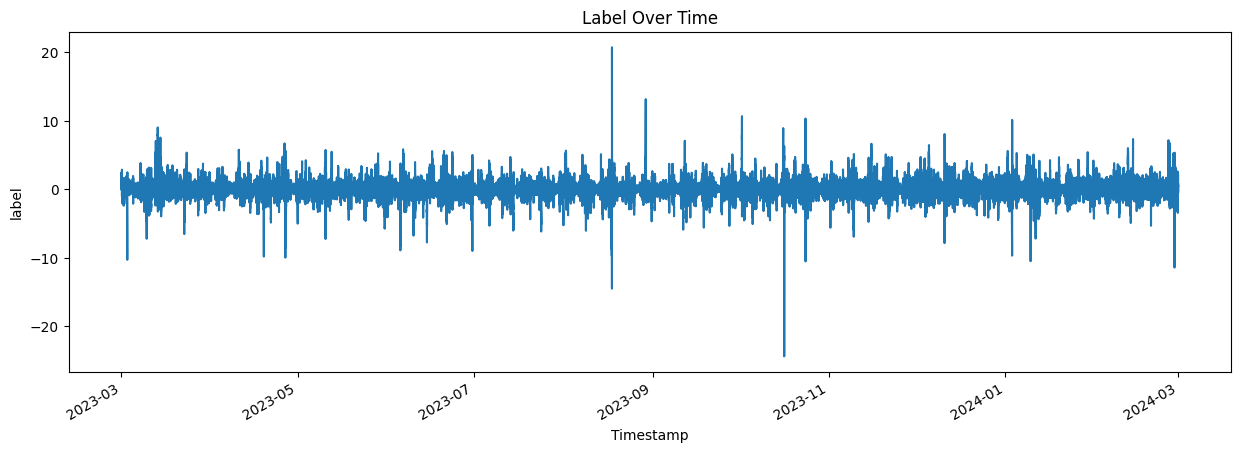

In [15]:
plt.figure(figsize=(15,5))
train_df['label'].plot()
plt.title("Label Over Time")
plt.xlabel("Timestamp")
plt.ylabel("label")
plt.show()

### What those spikes mean:

* The target usually hovers near zero.

* Occasionally, there are sharp spikes (big positive or negative jumps).

* Those spikes could represent rare events, anomalies, or important signals that might heavily influence your model.

### Smooth the series to see trends better

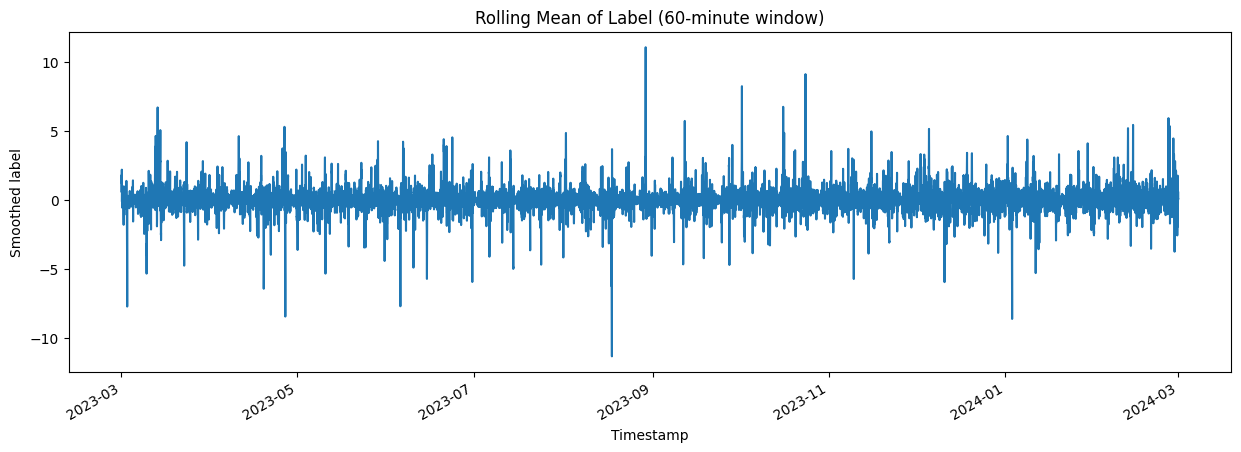

In [16]:
train_df['label'].rolling(window=60).mean().plot(figsize=(15,5))
plt.title("Rolling Mean of Label (60-minute window)")
plt.xlabel("Timestamp")
plt.ylabel("Smoothed label")
plt.show()

## Autocorrelation plot

* We ran autocorrelation plot to see if the target values relate to past values.

* This tells you if there’s a time dependency (important for time series).

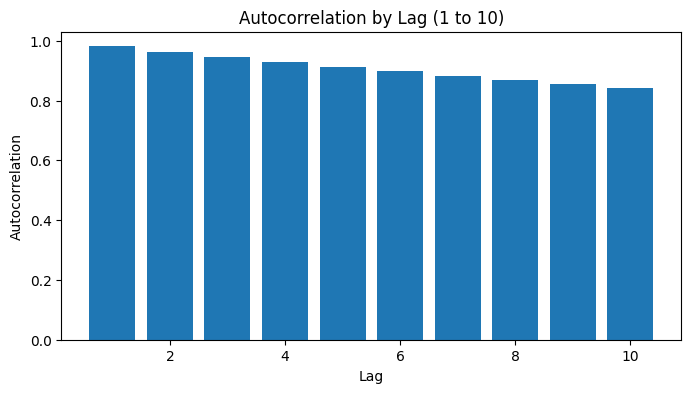

In [17]:
lags = list(range(1, 11))
autocorrs = [train_df['label'].autocorr(lag=lag) for lag in lags]

plt.figure(figsize=(8,4))
plt.bar(lags, autocorrs)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation by Lag (1 to 10)')
plt.show()

In [18]:
for lag in range(1, 11):
    autocorr = train_df['label'].autocorr(lag=lag)
    print(f"Autocorrelation at lag {lag}: {autocorr:.4f}")

Autocorrelation at lag 1: 0.9812
Autocorrelation at lag 2: 0.9627
Autocorrelation at lag 3: 0.9455
Autocorrelation at lag 4: 0.9293
Autocorrelation at lag 5: 0.9137
Autocorrelation at lag 6: 0.8983
Autocorrelation at lag 7: 0.8837
Autocorrelation at lag 8: 0.8692
Autocorrelation at lag 9: 0.8549
Autocorrelation at lag 10: 0.8406


### What the numbers mean ?

* Lag 1 autocorrelation ~ 0.98 is very high.

* Even at lag 10, the autocorrelation is still around 0.84 — that’s a strong positive correlation.

* This means your target variable is highly dependent on its recent past values — very typical for smooth, slowly changing time series.

* The target is not white noise at all.

* It’s very auto-correlated — past values strongly influence future ones.

* Models that capture temporal dependencies (like ARIMA, LSTM, or feature-engineered lags) might perform well.

## Check Skewness of Your Target

In [19]:
skewness = train_df['label'].skew()
print(f"Skewness of label: {skewness:.4f}")

Skewness of label: -0.1135


### Great! A skewness of -0.1135 means:

* The target distribution is slightly negatively skewed (left tail a bit longer).

* But since it’s very close to zero (|skew| < 0.5 is usually considered low), The distribution is fairly symmetric.

* This suggests you probably don’t need to do a transformation just for skewness.

# Step 4: Preprocessing

## Adding lag features

In [20]:
# Define safe base features to lag
lag_columns = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
n_lags = 3

def create_lag_features(df, columns, n_lags):
    for col in columns:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Apply on full train_df (before train/val split)
train_df = create_lag_features(train_df.copy(), lag_columns, n_lags)
train_df.dropna(inplace=True)

# Apply same on test_df (safe, since label column is 0 and not used for lag)
test_df = create_lag_features(test_df.copy(), lag_columns, n_lags)
test_df.dropna(inplace=True)  # optional

del lag_columns
del n_lags

## Rolling Statistics (Moving Averages, Std, etc.)

In [21]:
def add_rolling_features(df, columns, windows):
    for col in columns:
        for window in windows:
            df[f'{col}_rollmean{window}'] = df[col].rolling(window).mean()
            df[f'{col}_rollstd{window}'] = df[col].rolling(window).std()
    return df

rolling_columns = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
rolling_windows = [3, 5, 10]

# Apply rolling stats
train_df = add_rolling_features(train_df.copy(), rolling_columns, rolling_windows)
train_df.dropna(inplace=True)  # Drop initial rows with NaNs from rolling

test_df = add_rolling_features(test_df.copy(), rolling_columns, rolling_windows)
test_df.dropna(inplace=True)  # Optional

del rolling_columns
del rolling_windows

These features compute summary statistics over a sliding window of past values. Common ones:

* rolling_mean_5 → average of the past 5 rows

* rolling_std_5 → standard deviation of the past 5 rows

* Others: min, max, median, etc.

This helps smooth out noise and capture trends in recent data.

 ## Ratio & Delta Features

In [22]:
train_df['buy_sell_ratio'] = train_df['buy_qty'] / (train_df['buy_qty'] + train_df['sell_qty'] + 1e-6)
train_df['bid_ask_ratio'] = train_df['bid_qty'] / (train_df['ask_qty'] + 1e-6)
train_df['bid_ask_spread'] = train_df['ask_qty'] - train_df['bid_qty']
train_df['volume_normalized'] = train_df['volume'] / (train_df['bid_qty'] + train_df['ask_qty'] + 1e-6)

In [23]:
test_df['buy_sell_ratio'] = test_df['buy_qty'] / (test_df['buy_qty'] + test_df['sell_qty'] + 1e-6)
test_df['bid_ask_ratio'] = test_df['bid_qty'] / (test_df['ask_qty'] + 1e-6)
test_df['bid_ask_spread'] = test_df['ask_qty'] - test_df['bid_qty']
test_df['volume_normalized'] = test_df['volume'] / (test_df['bid_qty'] + test_df['ask_qty'] + 1e-6)

In financial data, relationships between variables can matter more than raw values.
For example:

* Buy/Sell pressure = buy_qty / (buy_qty + sell_qty)

* Bid/Ask spread = ask_qty - bid_qty or ask_qty / bid_qty

* Volume normalized = volume / (bid_qty + ask_qty)

These features help the model understand market imbalances or liquidity trends.

## Interaction Features

In [24]:
# On train_df
train_df['buy_bid_interaction'] = train_df['buy_qty'] * train_df['bid_qty']
train_df['sell_ask_interaction'] = train_df['sell_qty'] * train_df['ask_qty']
train_df['volume_buy_ratio'] = train_df['volume'] * train_df['buy_sell_ratio']
train_df['volume_spread'] = train_df['volume'] * train_df['bid_ask_spread']

In [25]:
# On test_df
test_df['buy_bid_interaction'] = test_df['buy_qty'] * test_df['bid_qty']
test_df['sell_ask_interaction'] = test_df['sell_qty'] * test_df['ask_qty']
test_df['volume_buy_ratio'] = test_df['volume'] * test_df['buy_sell_ratio']
test_df['volume_spread'] = test_df['volume'] * test_df['bid_ask_spread']

They are combinations of two or more existing features — capturing nonlinear relationships.

Example:

* buy_qty * bid_qty might signal aggressive buying

* volume * ask_qty could indicate high activity on the ask side

* buy_sell_ratio * volume combines pressure and size

These can help tree-based models like XGBoost detect complex patterns.

## Time-Based Features

In [26]:
# Train df overview
print("Train df index dtype:", train_df.index.dtype)
print("Train df head (index + some columns):")
print(train_df.iloc[:5, :10])  # show first 5 rows and first 10 columns

# Test df overview
print("\nTest df index dtype:", test_df.index.dtype)
print("Test df head (index + some columns):")
print(test_df.iloc[:5, :10])  # show first 5 rows and first 10 columns

# Check if test_df has any timestamp-like columns (besides index)
print("\nTest df columns with datetime dtype:")
print(test_df.select_dtypes(include=['datetime64[ns]']).columns.tolist())

# Check range of indices (to see if they look like time steps)
print("\nTrain index range:", train_df.index.min(), "to", train_df.index.max())
print("Test index range:", test_df.index.min(), "to", test_df.index.max())


Train df index dtype: datetime64[ns]
Train df head (index + some columns):
                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:12:00   11.835   12.583  103.717    85.207  188.924  0.575662   
2023-03-01 00:13:00    0.424   26.811  118.532    77.018  195.550 -0.260888   
2023-03-01 00:14:00   18.633    3.923  172.120    81.307  253.427 -0.201081   
2023-03-01 00:15:00    3.804   22.232   94.469   114.664  209.133 -0.227021   
2023-03-01 00:16:00    2.119   36.207  136.579   212.264  348.843 -0.313759   

                           X2        X3        X4        X5  
timestamp                                                    
2023-03-01 00:12:00  0.350401  0.747750  0.926403  0.485367  
2023-03-01 00:13:00 -1.202454 -0.895500 -0.734456 -0.348281  
2023-03-01 00:14:00 -0.984400 -0.750857 -0.604763 -0.286090  
2023-03-01 00:15:00 -0.942074 -0.776844 -0.645879 -0.309452  

Train Data
* Index is a proper datetime (minute-level timestamps from 2023-03-01 to 2024-02-29).

* Perfect for extracting time-based features like hour, dayofweek, cyclical encoding.

Test Data
* Index is integer-based (IDs from 13 to 538,150), no datetime columns.

* No timestamp info available in columns.

* So no direct time info in test data.

This means if you train a model using time features, it might rely on info unavailable at test time → causing a mismatch and hurting predictions.

In [27]:
# Reset index to turn timestamp index into a column
train_df = train_df.reset_index()

# Drop the timestamp column
train_df = train_df.drop(columns=['timestamp'])

# Now train_df has a default integer index and no timestamp column
print(train_df.shape)

(525875, 928)


## Spliting the data

In [28]:
df_train, df_valid = train_test_split(train_df, test_size=0.2, random_state=42)

# 2. Separate features and target
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

X_valid = df_valid.drop(columns=['label'])
y_valid = df_valid['label']

## Apply clipping on train and valid separately with the train thresholds

* The extreme spikes (the really tall peaks and deep troughs above or below ±5) will now be cut off or limited at those thresholds.

* So instead of those huge jumps going to, say, +20 or -24, the clipped values will max out at +5 or -5.

* This makes the smoothed curve less wild, easier to analyze, and less sensitive to rare extreme values.

* It helps your model not get overwhelmed by extreme outliers, which can distort learning.



In [29]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

In [30]:
# For IQR clipping, you might want to handle edge cases
if low < high:  # Ensure valid bounds
    y_train_clipped = y_train.clip(low, high)
    y_valid_clipped = y_valid.clip(low, high)
else:
    # Handle case where IQR is very small
    y_train_clipped = y_train.copy()
    y_valid_clipped = y_valid.copy()

# Step 6: Train on full training data

## XGBoost

In [31]:
# Prepare DMatrix (optional but recommended for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train_clipped)
dvalid = xgb.DMatrix(X_valid, label=y_valid_clipped)

In [32]:
del train_df

del y_train
del y_valid

del X_train
del X_valid

In [33]:
# Set XGBoost parameters (regression example)
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",  # fast histogram algorithm
    "seed": 42
}
evals = [(dtrain, "train"), (dvalid, "valid")]

## Without any new Feature 

In [34]:
# Train with early stopping on validation
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=10
)

[0]	train-rmse:0.72462	valid-rmse:0.72453
[10]	train-rmse:0.63525	valid-rmse:0.63679
[20]	train-rmse:0.57185	valid-rmse:0.57620
[30]	train-rmse:0.52587	valid-rmse:0.53277
[40]	train-rmse:0.48807	valid-rmse:0.49687
[50]	train-rmse:0.45340	valid-rmse:0.46400
[60]	train-rmse:0.42255	valid-rmse:0.43461
[70]	train-rmse:0.39850	valid-rmse:0.41129
[80]	train-rmse:0.37939	valid-rmse:0.39320
[90]	train-rmse:0.36198	valid-rmse:0.37668
[100]	train-rmse:0.34500	valid-rmse:0.36068
[110]	train-rmse:0.32891	valid-rmse:0.34536
[120]	train-rmse:0.31369	valid-rmse:0.33095
[130]	train-rmse:0.30028	valid-rmse:0.31840
[140]	train-rmse:0.29092	valid-rmse:0.31006
[150]	train-rmse:0.27976	valid-rmse:0.29992
[160]	train-rmse:0.27010	valid-rmse:0.29113
[170]	train-rmse:0.26087	valid-rmse:0.28296
[180]	train-rmse:0.25330	valid-rmse:0.27590
[190]	train-rmse:0.24439	valid-rmse:0.26770
[200]	train-rmse:0.23732	valid-rmse:0.26129
[210]	train-rmse:0.23135	valid-rmse:0.25576
[220]	train-rmse:0.22507	valid-rmse:0.25030

In [35]:
# Predict on validation set
y_pred = model.predict(dvalid)

In [36]:
# Evaluate
rmse = mean_squared_error(y_valid_clipped, y_pred, squared=False)
r2 = r2_score(y_valid_clipped, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R2: {r2:.4f}")

Validation RMSE: 0.1479
Validation R2: 0.9596


That’s a very strong result, especially for a time series regression task:

RMSE = 0.1453 → low absolute error

R² = 0.9611 → the model explains 96.11% of the variance in the target!

That means the model is capturing the dynamics of the data really well, at least on the validation set.

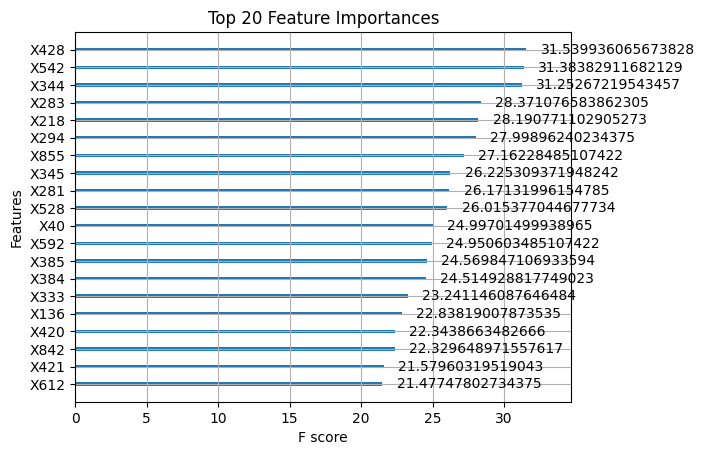

In [37]:
# Top 20 features by average gain (most useful metric)
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()

## With new Features

In [ ]:
X_test = test_df.drop(columns = ['label'])

dtest = xgb.DMatrix(X_test)

# Make predictions on test set
xgb_test_preds = model.predict(dtest)

# Generate row IDs (starting at 1)
row_ids = range(1, len(xgb_test_preds) + 1)

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': row_ids,
    'prediction': xgb_test_preds
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved: submission.csv")
